# Real-World Results

With the above analysis in place, we're ready to look at real world data.

## Blaze Rod Drops

We will begin with the Blaze rod data. The MST report gathered data for five distinct random-seed any-percent Minecraft 1.16 speedrunners: Benex, Dream, Illumina, Sizzler, and Vadikus007.

In [4]:
# Execute this cell to install all dependencies locally
!pip -q install --user mpmath myst_nb numpy pandas matplotlib scipy

In [5]:
from fractions import Fraction

from math import log,factorial
import matplotlib.pyplot as plt
from mpmath import mp
from myst_nb import glue

import numpy as np

import pandas as pd
from scipy.optimize import differential_evolution
from scipy.stats import beta,binom,nbinom


dpi         = 200  # change this to increase/decrease the resolution charts are made at
book_output = True # changing this to False will make it easier to view plots in a Jupyter notebook

def fig_show( fig, name ):
    """A helper to control how we're displaying figures."""
    global book_output
    
    if book_output:
        glue( name, fig, display=False )
        plt.close();
    else:
        fig.show()

In [6]:
# missing the data files? Uncommenting and running this cell might retrieve them
# !mkdir data
# !wget -P data "https://raw.githubusercontent.com/hjhornbeck/bayes_speedrun_cheating/main/data/blaze.benex.tsv"
# !wget -P data "https://raw.githubusercontent.com/hjhornbeck/bayes_speedrun_cheating/main/data/blaze.dream.tsv"
# !wget -P data "https://raw.githubusercontent.com/hjhornbeck/bayes_speedrun_cheating/main/data/blaze.illumina.tsv"
# !wget -P data "https://raw.githubusercontent.com/hjhornbeck/bayes_speedrun_cheating/main/data/blaze.sizzler.tsv"
# !wget -P data "https://raw.githubusercontent.com/hjhornbeck/bayes_speedrun_cheating/main/data/blaze.vadikus007.tsv"

In [7]:
blaze_players = ['benex','dream','illumina','sizzler','vadikus007']
pearl_players = ['benex','dream_before','dream_after','illumina','sizzler','vadikus007']

In [8]:
colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']  # makes colouring some of the following easier

blaze_rods = {p:pd.read_csv(f'data/blaze.{p}.tsv',sep="\t") for p in blaze_players}

blaze_rods['dream'].set_index('n').transpose()

n,12,11,16,10,13,11,5,4,1,14,...,9,10,15,10,15,11,9,10,9,9
k,6,7,8,7,8,8,5,3,1,8,...,8,6,8,7,7,7,7,7,7,8


We'll use the same chart as before, which shows how the Bayes factor changes as new data is added. This responds to a critique of the PE report: if the same trend is observed regardless of whether or not the last datapoint is dropped, we can be reasonably confident it was not an artifact of our stopping point.

As promised, we will determine how much influence the prior has by varying the scale parameter. My prefered value of 4 will be multiplied by both $\frac 1 3$ and 3, forming an "envelope" around it. The higher multiplier will "tug" the posterior towards the default hypothesis, while for better or worse the lower gives the data more power to shape the posterior.

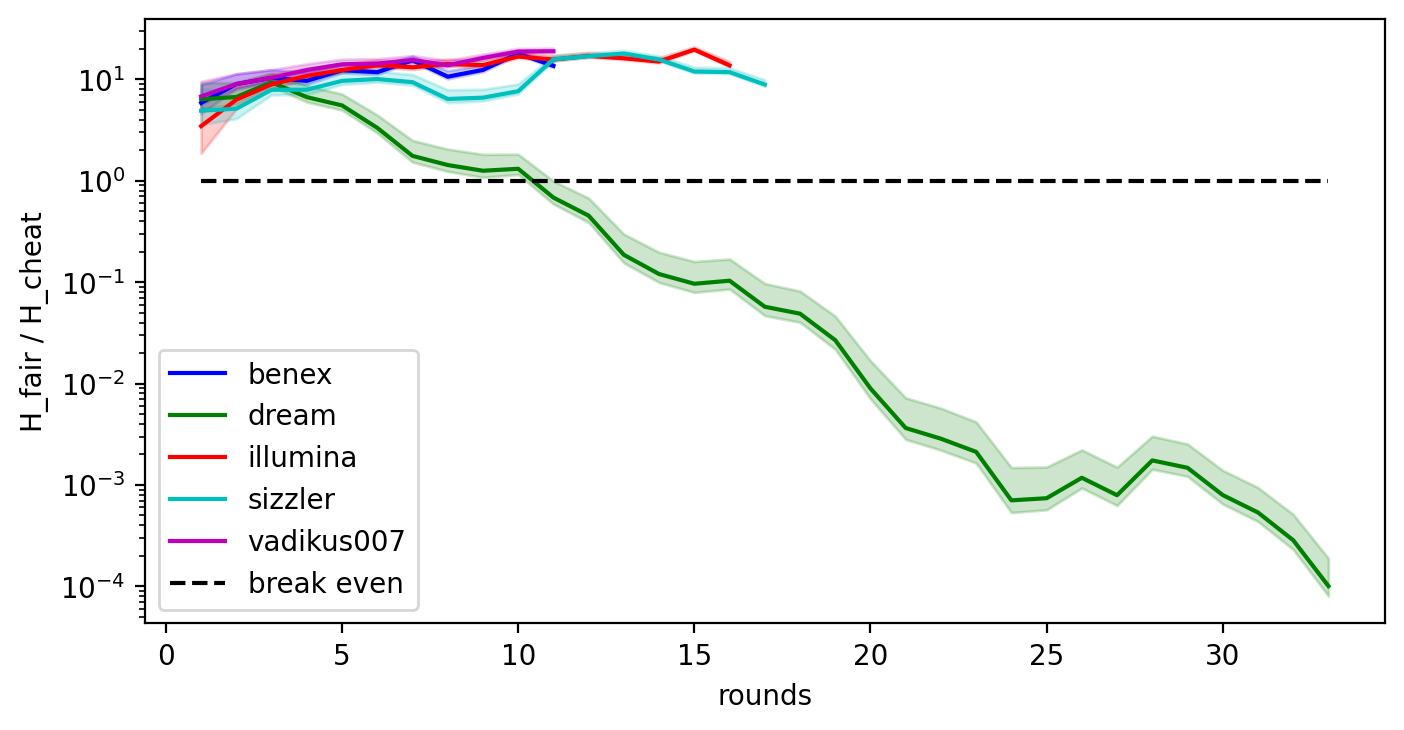

In [51]:
r_fair = Fraction(1,2)
priors = [prior( r_fair, scale ) for scale in [Fraction(4,3), 4, 12]]
    
fig = plt.figure(figsize=(8, 4), dpi=dpi, facecolor='w', edgecolor='k')

max_count = 0

for i,p in enumerate(blaze_players):
    
    count = len(blaze_rods[p])
    if count > max_count:
        max_count = count
        
    x     = np.arange(1, count+1)
    sum_n = np.cumsum( blaze_rods[p]['n'] )
    sum_k = np.cumsum( blaze_rods[p]['k'] )

    y = [BF_H_fair_H_cheat(sum_k[i], sum_n[i], r_fair, *priors[1]) for i in range(count)]
    plt.plot( x, y, '-', label=p, c=colours[i] )
    
    y_low = [BF_H_fair_H_cheat(sum_k[i], sum_n[i], r_fair, *priors[0]) for i in range(count)]
    y_hig = [BF_H_fair_H_cheat(sum_k[i], sum_n[i], r_fair, *priors[2]) for i in range(count)]
    plt.fill_between( x, [float(v) for v in y_low], [float(v) for v in y_hig], alpha=0.2, color=colours[i] )

x = range(1,max_count+1)
plt.plot( x, [1 for v in x], '--k', label='break even' )

plt.xlabel("rounds")
plt.ylabel('H_fair / H_cheat')
plt.yscale("log")

plt.legend()
plt.show()

Figure \ref{fig:data_blaze} shows that the Bayes factor for Dream's Blaze rod drop rate behaves differently from other Minecraft speedrunners. It drops like the cheating players from Figure \ref{fig:sim_blaze_trio}, but at a much sharper rate. Removing the last datapoint would not remove that trend. There is evidence of some of the other runners curving back towards the 1:1 odds line, but that is consistent with random fluctuations due to normal gameplay. Altering the prior has little effect, though the log scaling can be deceptive; the Bayes factor for Dream's round 33 using the scale 4 prior is half the size of the BF for the scale 12 prior.

In [73]:
r_fair         = Fraction(1,2)
sum_n          = blaze_rods['dream']['n'].sum()
sum_k          = blaze_rods['dream']['k'].sum()
dream_blaze_bf = BF_H_fair_H_cheat( sum_k, sum_n, r_fair, *prior(r_fair,4) )

print( f"The Bayes factor for Dream's Blaze rod rate, over all his rounds and with the scale 4 prior," + \
       f" is {mp.nstr(dream_blaze_bf,3)}, or about 1:{int(mp.fdiv(1,dream_blaze_bf)):,}." )

The Bayes Factor for Dream's Blaze rod rate, over all his rounds and with the scale 4 prior, is 0.000101, or about 1:9,930.


The resulting Bayes factor is roughly equivalent to the average golfer [landing a hole in one](https://www.pga.com/archive/odds-hole-in-one-albatross-condor) on their next shot. In comparison, the p-value for Dream's Blaze rod drop rate in the MST report is $4.72 \times 10^{-11}$, a difference of seven orders of magnitude, so on the surface it does seem true that Bayesian statistics is inherently more sluggish to respond to the data.

The PE report puts the probability of fair play at $3 \times 10^{-8},$ however. Why do two Bayesian analyses come to two very different results? The PE report analyzed Dream's drop rate by calculating a grid of probabilities ranging from $\frac 1 2$ to $\frac 9 {10}$, then taking the result for $r_\text{blaze} = \frac 1 2$ as the probability of fair play (pg. 10). This is analogous to the idealized dart board of a prior argument, which by necessity will lead to more extreme values. By integrating over an area, my definition of both $H_\text{fair}$ and $H_\text{cheat}$ account for the random fluctuations we would expect from random data, which necessarily waters down the probabilities of each. The PE report also does not factor in the probability of $H_\text{cheat}$. If that hypothesis is unlikely, then the relative likelihood of $H_\text{fair}$ is boosted proportionately.

Figure \ref{fig:data_blaze} only tells us the relative probabilities of $H_\text{fair}$ to $H_\text{cheat}$, unfortunately. It gives no indication of what the most credible drop rate is. For that, we need to chart the posteriers for each player. I'll show the results with the same range of prior scalings as Figure \ref{fig:data_blaze}.

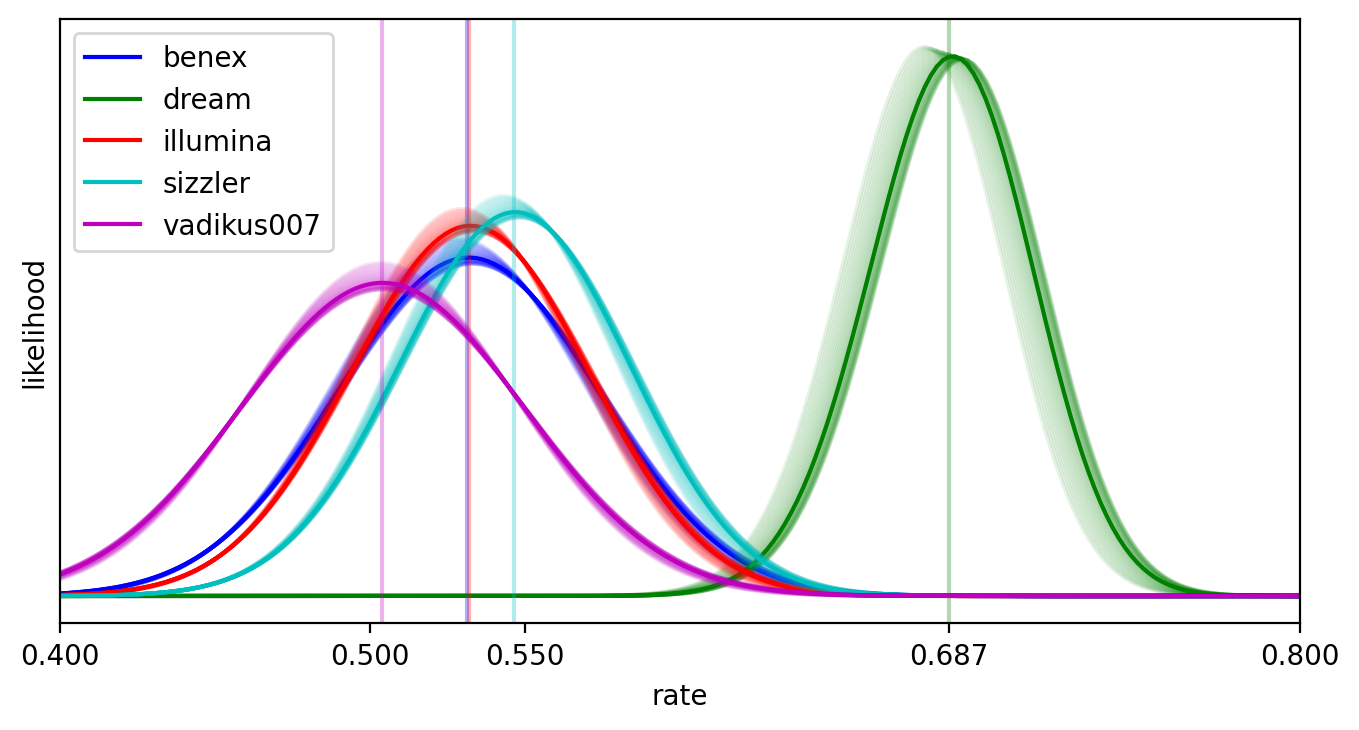

In [53]:
r_fair = Fraction(1,2)

fig = plt.figure(figsize=(8, 4), dpi=dpi, facecolor='w', edgecolor='k')

dream_mean = 0  # store Dream's mean value here

# fill_between doesn't give good output here. Instead, spam priors!
priors = [prior( r_fair, scale ) for scale in np.exp(np.linspace( np.log(4/3), np.log(12), 32 ))]
a_prior, b_prior = prior( r_fair, 4 )

x = np.linspace( 0, 1, 512 )
for i,p in enumerate(blaze_players):

    sum_n = np.sum( blaze_rods[p]['n'] )
    sum_k = np.sum( blaze_rods[p]['k'] )
    
    plt.plot( x, beta.pdf( x, float(a_prior + sum_k), float(b_prior + sum_n - sum_k) ), \
             '-', label=p, c=colours[i] )
    for pr in priors:
        plt.plot( x, beta.pdf( x, float(pr[0] + sum_k), float(pr[1] + sum_n - sum_k) ), \
             '-', alpha=0.1, c=colours[i] )

    plt.axvline( (a_prior + sum_k)/(a_prior + b_prior + sum_n), c=colours[i], alpha=0.3 )
    
    if p == 'dream':
        dream_mean = (a_prior + sum_k)/(a_prior + b_prior + sum_n)
    
plt.xlabel("rate")
plt.xlim( [.4,.8] )
plt.xticks( [.4, .5, .55, float(dream_mean), .8] )
plt.ylabel('likelihood')
plt.yticks([])

plt.legend()
plt.show()

According to Figure \ref{fig:data_blaze_pos}, the posterior distributions of other Minecraft players cluster on the generous side of 50:50 odds. Sizzler is the largest outlier, with the mean of his posterior approaching 55\%, but even for them a substantial amount of credence is present for $r_\text{blaze} \le \frac 1 2$. Dream again stands alone, with the posterior's mean drop rate above $\frac 2 3$ and almost no credence around $r_\text{blaze} \le \frac 1 2$. This is similar to what the PE report's estimate of "around 0.7" (pg. 10). Strengthening the prior clusters the credence more tightly around $r_\text{blaze} = \frac 1 2$, but there is sufficient data to make the effect subtle at best.

In [66]:
r_fair           = Fraction(1,2)
sum_n            = blaze_rods['dream']['n'].sum()
sum_k            = blaze_rods['dream']['k'].sum()
a_prior, b_prior = prior(r_fair,4)

intervals = beta.ppf( [.025, .16, .84, .975], float(a_prior + sum_k), float(b_prior + sum_n - sum_k) )

print( "Given the above data and prior, about two-thirds of our credence for Dream's Blaze rod rate\n" + \
      f"  is in the interval [{intervals[1]:.3f}, {intervals[2]:.3f}], while about 95% is between " + \
      f"[{intervals[0]:.3f}, {intervals[3]:.3f}]." )

Given the above data and prior, about two-thirds of our credence for Dream's Blaze rod rate
  is in the interval [0.661, 0.713], while about 95% is between [0.635, 0.737].


It's quite common to generate confidence or credible intervals around some parameter you're estimating. Those can reiterate some of the problems of p-values, such as what the interval means or what counts as extreme, but most of those are rendered moot via Bayesian statistics and the Beta function. There is no hard and fast rule on how much credence should be contained within the interval. The traditional value of 95\% can be sensitive to extreme data, so I prefer $\frac 2 3$. Code \ref{code:blaze_credible_int} has the results for both.

# Ender Pearl Barters

We have two sources of data for Ender pearls. The MST report collected bartering data for five runners including Dream, and Dream himself provided [a spreadsheet](https://drive.google.com/file/d/1EvxcvO4-guI73FH5pMUJ-zEHhV-L1yuJ/view) collecting additional statistics. Accessing that spreadsheet requires giving Dream or a third party my Google account information, so I instead opted to use the subset of data listed in Appendix A of the PE report. This second source carries the label "dream_before", as the streams it was collected from come before Dream took some time off of Minecraft 1.16 Random seed speed runs. The MST's data on Dream is labelled "dream_after", for similar reasons.

This provides us with an easy way to consider which, if any, of the above cheating scenarios apply.

1. If Dream cheated, and if he altered his barter rate from the start, we would expect the BF of both datasets to act like cheating players from the simulation and both posteriors to have little credence around $r_\text{blaze} = \frac{20}{423}$.
2. If Dream cheated, but only after he took some time off, we would expect the BF of the "before" set to behave like any other Minecraft speedrunner while the BF of the "after" acts like a cheating player. The posteriors would, respectively, cluster around $\frac{20}{423}$ and higher than it.
3. If Dream cheated, but craftily reduced his barter rate to hide it, we would expect the BF of both datasets to act like cheating players. The posteriors would, respectively, cluster below $\frac{20}{423}$ and above it.

Scenario 1 has already been ruled out by the PE report, as it notes the additional data reduces the probability of Dream cheating (pg. 13).

In [40]:
bartering  = {p:pd.read_csv(f'data/bartering.{p}.tsv',sep="\t") for p in pearl_players}
    
bartering['dream_after'].set_index('n').transpose()

n,22,5,24,18,4,1,7,12,26,8,...,2,13,10,10,21,20,10,3,18,3
k,3,2,2,2,0,1,2,5,3,2,...,0,1,2,2,2,2,2,1,2,2


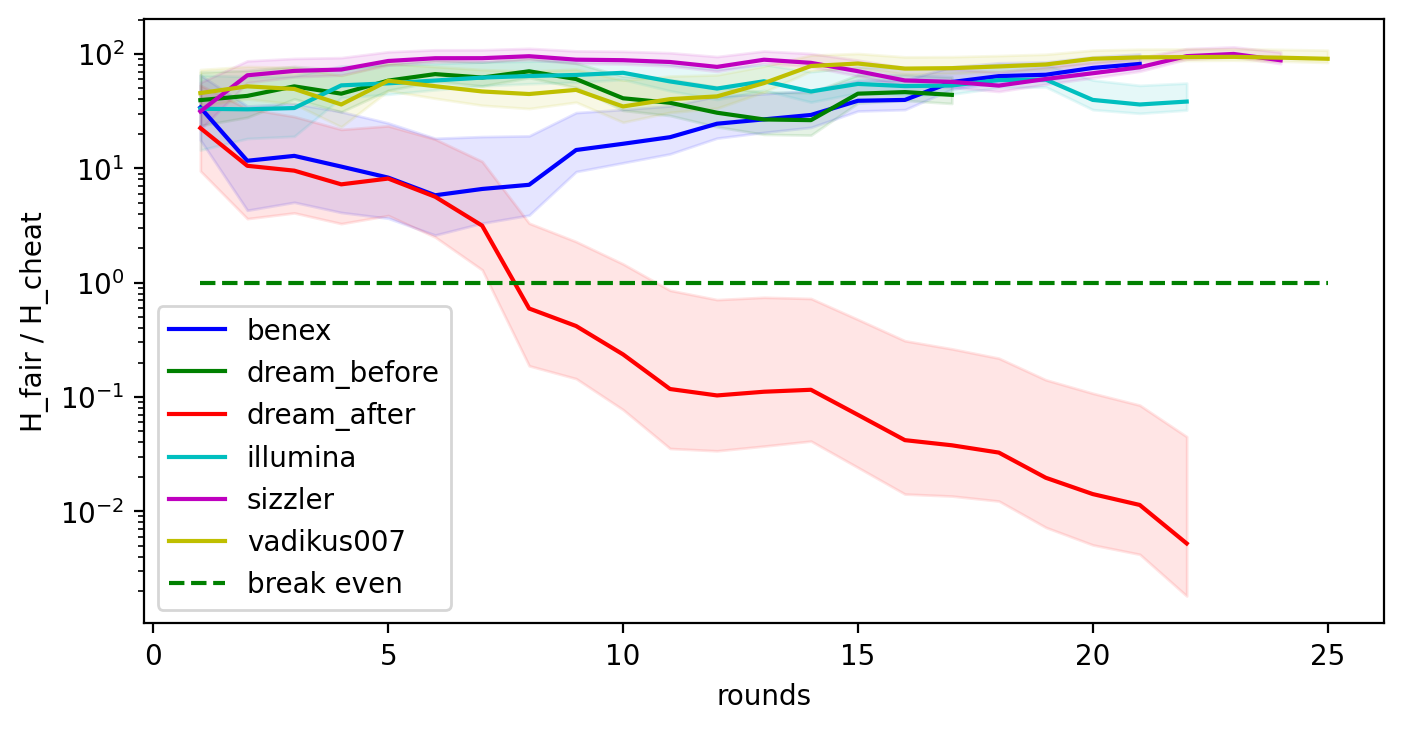

In [41]:
r_fair = Fraction(20,423)
priors = [prior( r_fair, scale ) for scale in [Fraction(4,3), 4, 12]]
    
fig = plt.figure(figsize=(8, 4), dpi=dpi, facecolor='w', edgecolor='k')

max_count = 0

for i,p in enumerate(pearl_players):
    
    count = len(bartering[p])
    if count > max_count:
        max_count = count
        
    x     = np.arange(1, count+1)
    sum_n = np.cumsum( bartering[p]['n'] )
    sum_k = np.cumsum( bartering[p]['k'] )

    y = [BF_H_fair_H_cheat(sum_k[i], sum_n[i], r_fair, *priors[1]) for i in range(count)]
    plt.plot( x, y, '-', label=p, c=colours[i] )
    
    y_low = [BF_H_fair_H_cheat(sum_k[i], sum_n[i], r_fair, *priors[0]) for i in range(count)]
    y_hig = [BF_H_fair_H_cheat(sum_k[i], sum_n[i], r_fair, *priors[2]) for i in range(count)]
    plt.fill_between( x, [float(v) for v in y_low], [float(v) for v in y_hig], alpha=0.1, color=colours[i] )

x = range(1,max_count+1)
plt.plot( x, [1 for v in x], '--g', label='break even' )

plt.xlabel("rounds")
plt.ylabel('H_fair / H_cheat')
plt.yscale("log")

plt.legend()
plt.show()

Figure \ref{fig:data_pearl} shows there's less certainty with this data. The same general pattern is present, with Dream's data after his break again behaving like the cheating player in the simulations. Other players and Dream's data before his break all behave more like fair players. Benex's first five rounds do show a downward trajectory, though this is compatible with a random good streak and their later data reverses the trajectory. This also suggests Scenario 3 is less likely than Scenario 2.

The choice of prior has a much stronger on the final outcome here than it did for Figure \ref{fig:data_blaze}, and the probabilities are about two orders of magnitude higher. The majority of this is due to the relative rarity of Ender pearl barters relative to Blaze rod drops, which waters down our credence for any given rate.

In [72]:
sum_n          = np.sum( bartering['dream_after']['n'] )
sum_k          = np.sum( bartering['dream_after']['k'] )
dream_pearl_bf = BF_H_fair_H_cheat( sum_k, sum_n, r_fair, *prior(r_fair,4) )

print( f"The Bayes factor for Dream's post-break Ender pearl barters, over all his rounds and with the scale 4 prior," + \
       f" is {mp.nstr(dream_pearl_bf,3)}, or about 1:{int(mp.fdiv(1,dream_pearl_bf)):,}." )

The Bayes Factor for Dream's post-break Ender pearl barters, over all his rounds and with the scale 4 prior, is 0.00523, or about 1:191.


With my scale 4 prior, the relative odds between $H_\text{fair}$ and $H_\text{cheat}$ are about the odds of [a US citizen dying of an accidental poisoning](https://www.floridamuseum.ufl.edu/shark-attacks/odds/compare-risk/death/).  Alternatively, if you work two hundred days a year and on average take one sick day off per year, the Bayes factor is roughly equivalent to being too sick to work on your next shift. A rare occurance, certainly, but not that rare.

For comparison, the MST report put the p-value of this at $8.04 \times 10^{-7}$, which differs by five orders of magnitude. p-values are not probabilities, though, so there is no direct comparison between the two. The PE report gives the probability of fair play at $3 \times 10^{-10}$ (pg. 11), but that number uses the same methodology as the one for Blaze rods and so the same criticisms apply.

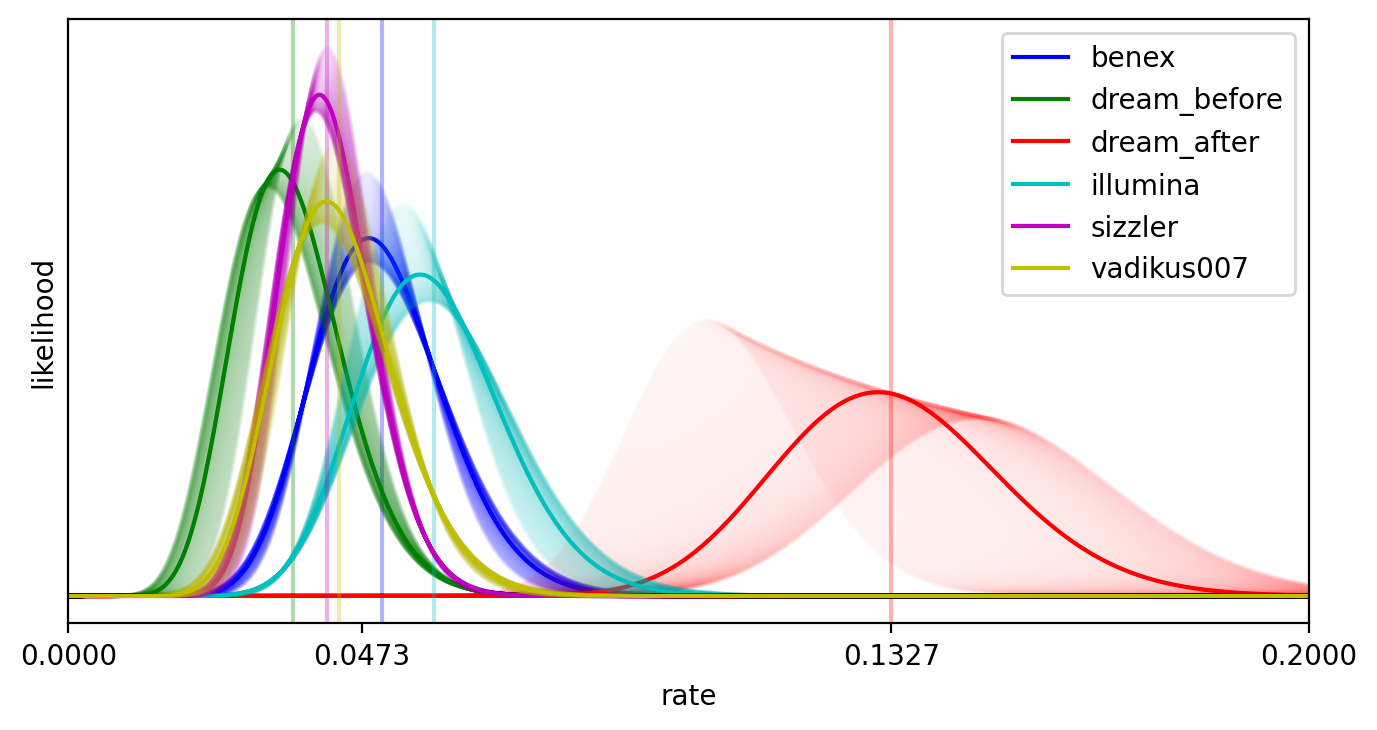

In [43]:
fig = plt.figure(figsize=(8, 4), dpi=dpi, facecolor='w', edgecolor='k')

dream_mean = 0  # store Dream's mean value here
dream_means = list()

# fill_between doesn't give good output here. Instead, spam priors!
priors = [prior( r_fair, scale ) for scale in np.exp(np.linspace( np.log(4/3), np.log(12), 128 ))]
a_prior, b_prior = prior( r_fair, 4 )

x = np.linspace( 0, .2, 512 )
for i,p in enumerate(pearl_players):

    sum_n = np.sum( bartering[p]['n'] )
    sum_k = np.sum( bartering[p]['k'] )
    
    plt.plot( x, beta.pdf( x, float(a_prior + sum_k), float(b_prior + sum_n - sum_k) ), \
             '-', label=p, c=colours[i] )
    for pr in priors:
        plt.plot( x, beta.pdf( x, float(pr[0] + sum_k), float(pr[1] + sum_n - sum_k) ), \
             '-', alpha=0.03, c=colours[i] )
        if p == 'dream_after':
            dream_means.append( (pr[0] + sum_k) / (pr[0] + pr[1] + sum_n) )

    plt.axvline( (a_prior + sum_k)/(a_prior + b_prior + sum_n), c=colours[i], alpha=0.3 )
    
    if p == 'dream_after':
        dream_mean = (a_prior + sum_k)/(a_prior + b_prior + sum_n)
    
plt.xlabel("rate")
plt.xlim( [0,.2] )
plt.xticks( [0, float(r_fair), float(dream_mean), .2] )
plt.ylabel('likelihood')
plt.yticks([])

plt.legend()
plt.show()

Figure \ref{fig:data_pearl_pos} shows all but one dataset hovers around the expected rate of Ender pearl barters. The posterior for Dream's performance before his break favours lower barter rates than all other runners, providing a little support for Scenario 3, but note that a non-trivial amount of its credence is greater than the expected barter rate. Overall, Scenario 2 remains more likely even before we incorporate the Bayes factor values. 

Dream's post-break performance again is quite different from other speedrunners and even his own pre-break performance, but this time prior strength is a major factor. It should be noted that my prior for Ender pearl barters is fairly strong. My scale 4 prior for Blaze rod drops is mathematically equivalent to a Bayes/Laplace prior with six "phantom" observations added that precisely match the expected drop rate. The scale 4 prior for Ender pearl drops is equivalent to Bayes/Laplace with three successful Ender pearl drops observed and slightly more than 81 failed attempts. With so many phantom observations, much more data is necessary to overcome the latter prior's weight, and conversely small changes to that prior will lead to significant changes in the posterior. Nonetheless, I still think it is a good fit for my prior beliefs about Ender pearl drop rates, in both the cheating and fair cases.

The mean value of Dream's post-break performance is approximately three times larger than the expected rate, which again matches what the PE report observed (pg. 11).

In [67]:
r_fair           = Fraction(20,423)
sum_n            = bartering['dream_after']['n'].sum()
sum_k            = bartering['dream_after']['k'].sum()
a_prior, b_prior = prior(r_fair,4)

intervals = beta.ppf( [.025, .16, .84, .975], float(a_prior + sum_k), float(b_prior + sum_n - sum_k) )

print( "Given the above data and prior, about two-thirds of our credence for Dream's Ender pearl barter rate\n" + \
      f"  is in the interval [{intervals[1]:.3f}, {intervals[2]:.3f}], while about 95% is between " + \
      f"[{intervals[0]:.3f}, {intervals[3]:.3f}]." )

Given the above data and prior, about two-thirds of our credence for Dream's Ender pearl barter rate
  is in the interval [0.115, 0.151], while about 95% is between [0.099, 0.170].


Code \ref{code:pearl_credible_int} computes the credible intervals for Ender pearl bartering rates. A common heuristic is to see if the value we expect to see is contained within the interval, and invoke modus tollens if it is not. I do not endorse that, but if you disagree then I'll simply note that the bartering rate for an unadulterated copy of Minecraft 1.16.1 is not contained in either interval.

## Combining Both Datasets

As mentioned prior, Bayes factors are likelihoods and can thus be multiplied together. This allows us to generate a combined odds ratio for both datasets.

In [71]:
dream_combo_bf = mp.fmul( dream_blaze_bf, dream_pearl_bf )

print( f"The Bayes factor for both rates, over all of Dream's post-break rounds and with the scale 4 prior," + \
       f" is {mp.nstr(dream_combo_bf,3)}, or about 1:{int(mp.fdiv(1,dream_combo_bf)):,}." )

The Bayes Factor for both rates, over all of Dream's post-break rounds and with the scale 4 prior, is 5.27e-7, or about 1:1,899,071.


The combined Bayes factor is quite low. To take an example, the median age of a Canadian in 2019 was [about 41 years old](https://www150.statcan.gc.ca/n1/daily-quotidien/190930/dq190930a-eng.htm). If we examine [the relevant mortuary tables](https://www150.statcan.gc.ca/n1/pub/84-537-x/2020001/xls/2017-2019_Tbl-eng.xlsx) and extrapolate the odds of dying per year to the odds of dying per day, then we'd place four times more credence on a specific 41-year-old Canadian woman dying within 24 hours (about 1:472,632) than we would for $H_\text{cheat}$ over $H_\text{fair}$.

As unlikely as that is, it's still seven orders of magnitude higher than the MST report's "loose upper bound" on Dream's success, which they declare is "almost certainly an overestimate" (pg. 22). After applying multiple corrections, the PE report concludes "there is a 1 in 100 million chance that a livestream in the Minecraft speedrunning community got as lucky this year on two separate random modes as Dream did in these six streams" (pg. 16), a number which is just about two order of magnitudes lower than what I calculate. The differences are entirely due to statistical methodology.

# Conclusion

I will refrain from stating conclusively that Dream boosted his Blaze rod drop and Ender pearl barter rate. To explain why, it is worth discussing stopping rules.

## Stopping Rules

Both the MST and PE reports invoke stopping rules, though in a way that is not congruent with how they are used within the scientific community.

> Suppose that a researcher is testing whether one variable influences another or is comparing two treatments
or effect sizes. Suppose also that the researcher is primarily interested in whether there is an effect (or difference) and, if so, the direction of the effect. Finally, suppose that the researcher wants to set alpha at .05, which is to say, have a 5% probability of rejecting the null hypothesis of no effect, if it is true.\footnote{As I said earlier, even professionals misunderstand p-values on a regular basis.} 

> Dsing the fixed-sample stopping rule, the researcher would determine the number of subjects to be tested prior to performing the study. However, there is another type of stopping rule, called sequential stopping rules, which was first proposed by Wald in 1947. In a sequential stopping rule, the outcome ofthe statistical test could lead to testing more subjects. Thus, the number of subjects to be tested is not fixed in advance.\cite{frick_better_1998}

> According to Wainer (2000) an adaptive test can be considered complete after a predetermined number of items have been administered, when a predetermined level of measurement precision has been reached, or when a predetermined length of time has elapsed. The two most commonly used methods for determining when a computerized adaptive test is complete are the fixed length and variable length stopping rules.

> Under a fixed length stopping rule, an adaptive test is terminated when a predetermined number of items have been administered. Accordingly, all examinees are administered the same number of items, regardless of the degree of measurement precision achieved upon termination of the test. \[...\]

> In contrast, variable length stopping rules typically seek to achieve a certain degree of measurement precision for all examinees, even when doing so means that some examinees are given more items than others. Two types of variable length stopping rules have been used (Dodd, Koch, & De Ayala, 1993). These are the standard error (SE) stopping rule and the minimum information stopping rule. Of these, the most commonly used has been the SE stopping rule, which terminates an adaptive test when a predetermined standard error has been reached for the most recent examinee trait estimate (Boyd, Dodd, & Choi, 2010).\cite{choi_new_2010}

> One criticism of rules like O'Brien and Fleming is their rigidity in requiring a fixed maximum number of preplanned interim analyses. Greater flexibility is possible with the Peto-Haybittle rule, which simply specifies a fixed p value (often $p<0-001$) for stopping early. For example, the European myocardial infarction amiodarone trial (EMIAT) is an ongoing study of 1500 patients at high risk after myocardial infarction comparing amiodarone (an antiarrhythmic drug) with placebo. Two year mortality is the primary end point, and the stopping guideline for efficacy is $p < 0.001$ in favour of amiodarone.\cite{pocock_when_1992}

A clear stopping rule is necessary when the number of datapoints you could look at is practically infinite; we could survey every single person in the United States to determine their political views, but it is more feasible to pick a large enough sample of them to achieve a certain statistical accuracy. Alternatively, we could flip between data gathering and analysis until our target accuracy or statistical measure is reached, but this risks coming to a premature stop due to statistical fluctuations; had we just analyzed X more datapoints, our test statistic would switch from "statistically significant" to "not statistically significant" and our declaration of significance would be premature.

Dream has not completed a practically infinite number of Minecraft 1.16 Random Seed Any \% runs, however. If our hypothesis is that Dream boosted his drop/barter rate since returning to that speedrun category, then the entire dataset consists of thirty-three runs where Blazes were killed for Blaze rods, and twenty-two runs where Ender pearls were bartered for, spread across six streaming sessions. There is no more data to be collected, and the data that is present is nowhere near large enough to pose an analytic challenge. If those datapoints were insufficient to establish the hypothesis, then a well-designed statistical test metric will conclude the evidence is inconclusive. If the fluctuations could be due to chance, then a well-designed metric will take that into account. The data cannot be cherry-picked to artificially boost the metric, as the MST report examines every applicable cherry.

The imposition of a binary decision threshold on continuous test statistics, and the resulting necessity of stopping rules, has led some researchers have called for the abandonment of statistical significance entirely.\cite{doi:10.1080/00031305.2018.1527253} Rather than have the researcher or publisher check if p-values or Bayes factors cross a certain threshold, they propose researchers and publishers take a holistic approach that also factors in "related prior evidence, plausibility of mechanism, study design and data quality, real world costs and benefits," and "novelty of finding" among other things.

As an outsider to the Minecraft speedrunning community, I do not have full knowledge of prior evidence. I do not have a good understanding of the costs or benefits of removing Dream's speed-running records, and should I make the wrong decision I will not pay the consequences. The best thing I can do is to instead lay out my full reasoning as clearly I can. If the community accepts the premises behind my arguements and can find few flaws in how I link them together, they are in a much better position to decide the best course of action.

# Future Work

While I cannot provide a solid yes or no, I have provided several things which may prove useful. My analysis above is applicable to any Bernoulli process where we do not know the true rate. If we have a hypothesis that the rate is a specific value, and no strong alternative hypothesis, then the two Python routines `posterior_H_fair()` and `BF_H_fair_H_cheat()` can be invoked to generate a Bayes factor for that hypothesis relative to another pseudo-inverse hypothesis. Both routines run quite fast; most of this notebook was developed on an [Asus Transformer](https://en.wikipedia.org/wiki/Asus_Transformer#Asus_Transformer_Book), and the slowest cell takes about thirty seconds to execute. Both routines are also quite flexible, as they allow arbitrary Beta priors to be supplied and use arbitrary precision to ensure math overflow isn't a problem. This makes those routines applicable well beyond the simple question of "did Dream cheat?"

I have also tried to make it as easy as possible to build another analysis on top of this one. If, for instance, you do not agree with my definition of $H_\text{cheat}$, you can develop your own mathematical version and use that to weight the posterior. Just as I tried to take the best parts of the MST and PE reports to build a new analysis, you could do the same with this report. 

For instance, one idea not explored here is heirarchical models. The PE report attempted to build such a model for Ender pearl barters using Monte Carlo simulations, but a better approach is to invoke [Stan](https://mc-stan.org/users/documentation/case-studies/radon.html) or [emcee](https://emcee.readthedocs.io/en/stable/tutorials/line/) to build and sample from the posterior. This would allow you to test the success rate of barters, the number of Ender pearls dropped per successful barter, and the amount of gold a speedrunner could gather simultaneously. Rather than assert whether the speedrunner's goal was ten or twelve Ender pearls, as the PE report's simulation does, they can be free parameters in the model that the MCMC engine will explore for you.

At minimum, I at least hope to have provided a different and more rigorous approach towards analyzing whether or not a speedrunner modified their game.